<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter03/model_perf_comparison_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use python 3.9.8 64 bit

In [28]:
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
)
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.under_sampling import (
    AllKNN,
    CondensedNearestNeighbour,
    EditedNearestNeighbours,
    InstanceHardnessThreshold,
    OneSidedSelection,
    RandomUnderSampler,
    NeighbourhoodCleaningRule,
    RepeatedEditedNearestNeighbours,
    TomekLinks,
)
from imblearn.datasets import fetch_datasets
from imblearn.combine import SMOTEENN, SMOTETomek

## Synthetic data set prep:

In [29]:
def make_data(sep):
    X, y = make_classification(
        n_samples=5000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.92],
        class_sep=sep,  # how separate the classes are
        random_state=1,
    )

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns=["feature_1", "feature_2"])
    y = pd.Series(y)

    return X, y

0    4581
1     419
dtype: int64


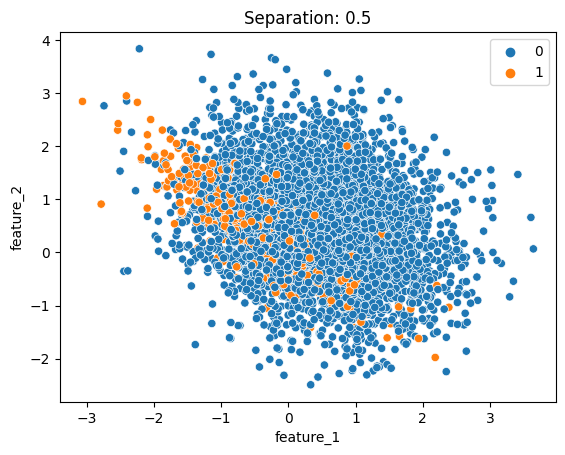

0    4581
1     419
dtype: int64


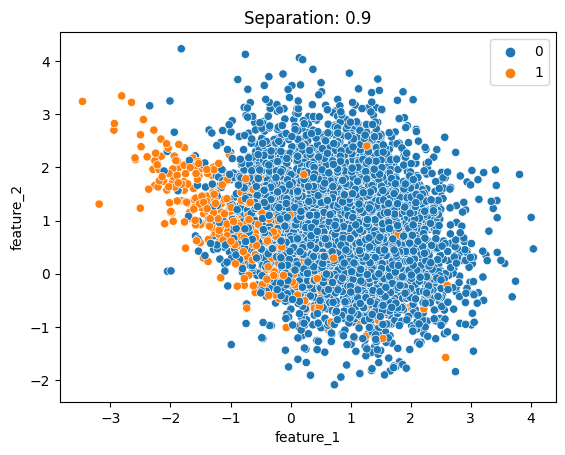

In [30]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [0.5, 0.9]:
    X, y = make_data(sep)
    synthetic_datasets.append(
        {
            "data": np.array(X),
            "target": np.array(y),
            "DESCR": "synthetic data, sep: " + str(sep),
        }
    )
    print(y.value_counts())
    sns.scatterplot(data=X, x="feature_1", y="feature_2", hue=y)
    plt.title("Separation: {}".format(sep))
    plt.show()

## Real world data set

In [31]:
# these datasets are baked into imbalanced-learn
dataset_list = ["thyroid_sick", "abalone_19"]

In [32]:
all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data["target"] = le.fit_transform(data["target"])
    all_datasets.append(data)

for item in all_datasets:
    print(Counter(item["target"]))

Counter({0: 4581, 1: 419})
Counter({0: 4581, 1: 419})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [33]:
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split, cross_validate

scaler = MinMaxScaler()


def run_model(classifier, X_train, y_train, undersampler=None):
    model = Pipeline(
        steps=[
            ("minMaxScaling", scaler),
            ("under", undersampler),
            ("model", classifier),
        ]
    )
    folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    cv_results = cross_validate(
        model, X_train, y_train, scoring="average_precision", cv=3, n_jobs=-1
    )
    print(
        "model: ",
        type(classifier).__name__,
        " | cv_results:",
        cv_results["test_score"].mean(),
    )
    return cv_results["test_score"].mean()

In [34]:
undersampler_map = {
    "Nosampling": None,
    "RandomUnderSampler": RandomUnderSampler(
        sampling_strategy="auto", random_state=0, replacement=False
    ),
    "condNearNeigh": CondensedNearestNeighbour(
        sampling_strategy="auto", random_state=0, n_neighbors=1, n_jobs=4
    ),
    "tomek": TomekLinks(sampling_strategy="auto", n_jobs=4),
    "oss": OneSidedSelection(
        sampling_strategy="auto", random_state=0, n_neighbors=1, n_jobs=4
    ),
    "enn": EditedNearestNeighbours(
        sampling_strategy="auto", n_neighbors=3, kind_sel="all", n_jobs=4
    ),
    "renn": RepeatedEditedNearestNeighbours(
        sampling_strategy="auto", n_neighbors=3, kind_sel="all", n_jobs=4, max_iter=100
    ),
    "allknn": AllKNN(sampling_strategy="auto", n_neighbors=3, kind_sel="all", n_jobs=4),
    "ncr": NeighbourhoodCleaningRule(
        sampling_strategy="auto",
        n_neighbors=3,
        kind_sel="all",
        n_jobs=4,
        threshold_cleaning=0.5,
    ),
    "insTh": InstanceHardnessThreshold(
        # estimator=LogisticRegression(random_state=0),
        sampling_strategy="auto",
        random_state=0,
        n_jobs=4,
        cv=3,
    ),
    "SMOTEENN": SMOTEENN(random_state=0),
    "SMOTETomek": SMOTETomek(random_state=0),
}

In [35]:
# now we train several models, with the different UnderSampling techniques and
# with cross-validation for each dataset
from sklearn.ensemble import RandomForestClassifier

# save results
pr_mean_dict_lr = {}
pr_mean_dict_rf = {}
pr_mean_dict_xgb = {}

for data in all_datasets:
    pr_mean_dict_lr[data["DESCR"]] = {}
    pr_mean_dict_rf[data["DESCR"]] = {}
    pr_mean_dict_xgb[data["DESCR"]] = {}

    for undersampler in undersampler_map.keys():
        print(undersampler, " | Dataset description: ", data["DESCR"])
        # set up the classifier
        lr = LogisticRegression(random_state=0, max_iter=10000)
        aps_mean_lr = run_model(
            lr, data["data"], data["target"], undersampler_map[undersampler]
        )
        pr_mean_dict_lr[data["DESCR"]][undersampler] = aps_mean_lr

        rf = RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=4
        )
        aps_mean_rf = run_model(
            rf, data["data"], data["target"], undersampler_map[undersampler]
        )
        pr_mean_dict_rf[data["DESCR"]][undersampler] = aps_mean_rf

        xgb = XGBClassifier()
        aps_mean_xgb = run_model(
            xgb, data["data"], data["target"], undersampler_map[undersampler]
        )
        pr_mean_dict_xgb[data["DESCR"]][undersampler] = aps_mean_xgb

        print()

Nosampling  | Dataset description:  synthetic data, sep: 0.5
model:  LogisticRegression  | cv_results: 0.2538508430294424
model:  RandomForestClassifier  | cv_results: 0.31260685950111095
model:  XGBClassifier  | cv_results: 0.27409699269056403

RandomUnderSampler  | Dataset description:  synthetic data, sep: 0.5
model:  LogisticRegression  | cv_results: 0.24275460488085984
model:  RandomForestClassifier  | cv_results: 0.2983273969018135
model:  XGBClassifier  | cv_results: 0.2541811987233676

condNearNeigh  | Dataset description:  synthetic data, sep: 0.5
model:  LogisticRegression  | cv_results: 0.27386168405523875
model:  RandomForestClassifier  | cv_results: 0.30634560674864525
model:  XGBClassifier  | cv_results: 0.22894799584184042

tomek  | Dataset description:  synthetic data, sep: 0.5
model:  LogisticRegression  | cv_results: 0.2553027381513537
model:  RandomForestClassifier  | cv_results: 0.3097963215572071
model:  XGBClassifier  | cv_results: 0.2897641045901503

oss  | Datas

In [36]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

print("\033[1m Logistic Regression, Average Precision")
df_lr = pd.DataFrame(pr_mean_dict_lr)
display(df_lr.round(3))
print("\n")

print("\033[1m Random Forest, Average Precision")
df_rf = pd.DataFrame(pr_mean_dict_rf)
display(df_rf.round(3))
print("\n")


print("\033[1m XGBoost Classifier, Average Precision")
df_xgb = pd.DataFrame(pr_mean_dict_xgb)
display(df_xgb.round(3))

 Logistic Regression, Average Precision


,"synthetic data, sep: 0.5","synthetic data, sep: 0.9",thyroid_sick,abalone_19
Nosampling,0.254,0.624,0.519,0.025
RandomUnderSampler,0.243,0.622,0.415,0.020
condNearNeigh,0.274,0.599,0.526,0.024
tomek,0.255,0.624,0.515,0.025
oss,0.254,0.623,0.516,0.024
enn,0.255,0.622,0.476,0.026
renn,0.252,0.619,0.449,0.025
allknn,0.254,0.620,0.463,0.025
ncr,0.255,0.622,0.475,0.026
insTh,0.223,0.609,0.421,0.025




 Random Forest, Average Precision


,"synthetic data, sep: 0.5","synthetic data, sep: 0.9",thyroid_sick,abalone_19
Nosampling,0.313,0.632,0.756,0.044
RandomUnderSampler,0.298,0.570,0.814,0.046
condNearNeigh,0.306,0.623,0.848,0.051
tomek,0.310,0.631,0.782,0.067
oss,0.310,0.631,0.786,0.063
enn,0.316,0.608,0.715,0.039
renn,0.318,0.589,0.735,0.041
allknn,0.321,0.603,0.731,0.063
ncr,0.318,0.603,0.741,0.060
insTh,0.275,0.523,0.715,0.046




 XGBoost Classifier, Average Precision


,"synthetic data, sep: 0.5","synthetic data, sep: 0.9",thyroid_sick,abalone_19
Nosampling,0.274,0.600,0.956,0.033
RandomUnderSampler,0.254,0.542,0.870,0.036
condNearNeigh,0.229,0.534,0.816,0.017
tomek,0.290,0.612,0.953,0.035
oss,0.287,0.604,0.952,0.032
enn,0.309,0.608,0.896,0.041
renn,0.287,0.546,0.895,0.028
allknn,0.299,0.609,0.891,0.031
ncr,0.314,0.594,0.923,0.029
insTh,0.269,0.461,0.757,0.030


Points to note:
1. Please note that the models used here are not tuned with the best hyperparameters.
Tuning XGBoost parameters would likely make it better than logistic regression here (for example, try with hyperparameters of {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2})

----------------------------------------------------------------

Table 1: Logistic Regression average preicision scores on synthetic data, sep: 0.5
----------------------------------------------------------------

                      lr
Nosampling          0.25
RandomUnderSampler  0.24
condNearNeigh       0.27
tomek               0.26
oss                 0.25
enn                 0.26
renn                0.25
allknn              0.25
ncr                 0.25
insTh               0.22
SMOTEENN            0.22
SMOTETomek          0.21
----------------------------------------------------------------

Table 2: Logistic Regression average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------

                      lr
Nosampling          0.62
RandomUnderSampler  0.62
condNearNeigh       0.60
tomek               0.62
oss                 0.62
enn                 0.62
renn                0.62
allknn              0.62
ncr                 

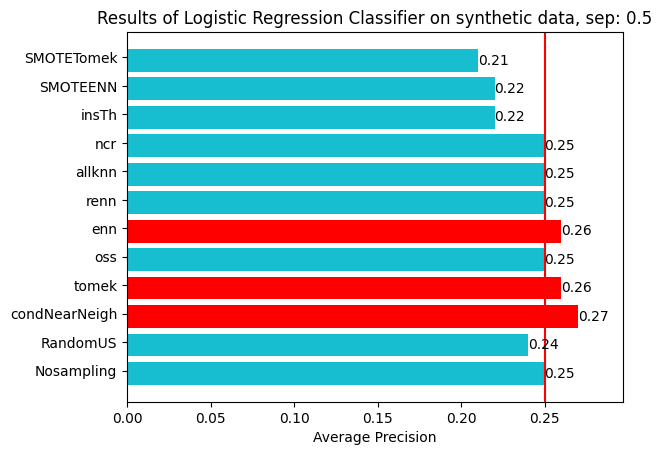

----------------------------------------------------------------

Figure 2: Logistic Regression average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------



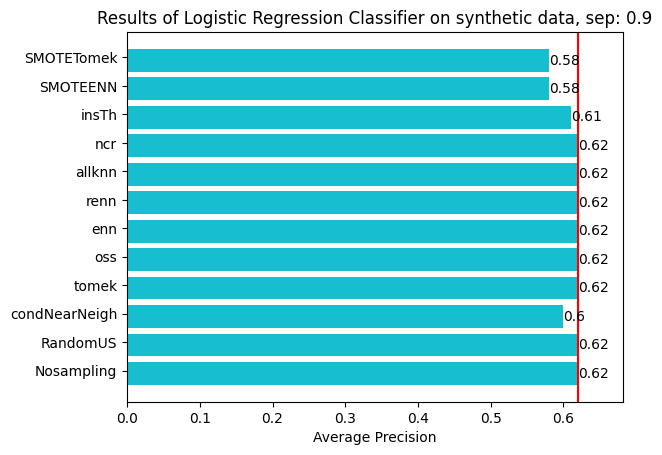

----------------------------------------------------------------

Figure 3: Logistic Regression average preicision scores on thyroid_sick
----------------------------------------------------------------



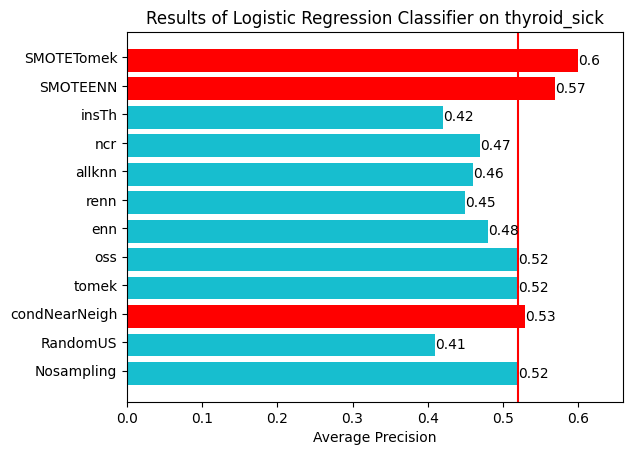

----------------------------------------------------------------

Figure 4: Logistic Regression average preicision scores on abalone_19
----------------------------------------------------------------



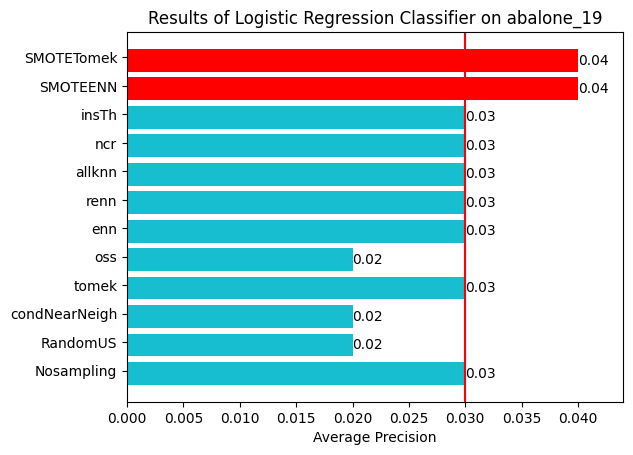

In [37]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": Logistic Regression average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_lr], index=["lr"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": Logistic Regression average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_lr], index=["lr"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 12):
        if df["lr"][j] > df["lr"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(12)  # plotting for 14 different undersampling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df["lr"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["lr"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(12)],
        [
            "Nosampling",
            "RandomUS",
            "condNearNeigh",
            "tomek",
            "oss",
            "enn",
            "renn",
            "allknn",
            "ncr",
            "insTh",
            "SMOTEENN",
            "SMOTETomek",
        ],
    )
    maximum = df["lr"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title(
        "Results of Logistic Regression Classifier on %s" % (all_datasets[i]["DESCR"])
    )
    ax.bar_label(ax.containers[0])
    plt.show()

----------------------------------------------------------------

Table 1: Random Forest average preicision scores  on synthetic data, sep: 0.5
----------------------------------------------------------------

                      rf
Nosampling          0.31
RandomUnderSampler  0.30
condNearNeigh       0.31
tomek               0.31
oss                 0.31
enn                 0.32
renn                0.32
allknn              0.32
ncr                 0.32
insTh               0.28
SMOTEENN            0.28
SMOTETomek          0.29
----------------------------------------------------------------

Table 2: Random Forest average preicision scores  on synthetic data, sep: 0.9
----------------------------------------------------------------

                      rf
Nosampling          0.63
RandomUnderSampler  0.57
condNearNeigh       0.62
tomek               0.63
oss                 0.63
enn                 0.61
renn                0.59
allknn              0.60
ncr                 0.60
insTh

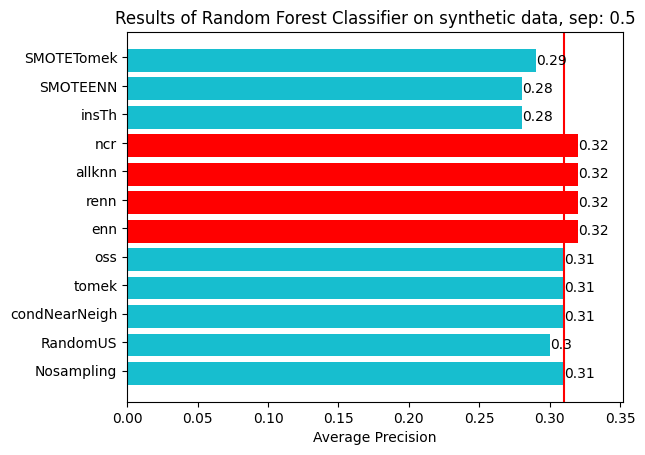

----------------------------------------------------------------

Figure 2: Random Forest average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------



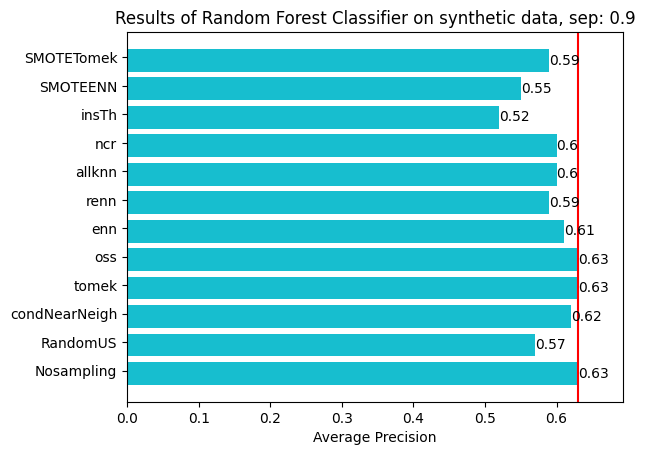

----------------------------------------------------------------

Figure 3: Random Forest average preicision scores on thyroid_sick
----------------------------------------------------------------



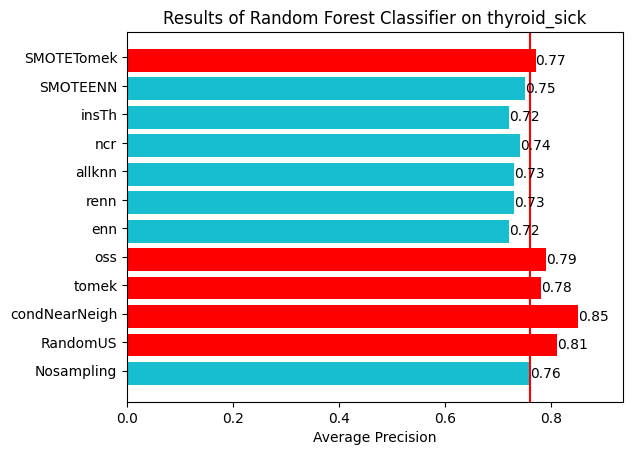

----------------------------------------------------------------

Figure 4: Random Forest average preicision scores on abalone_19
----------------------------------------------------------------



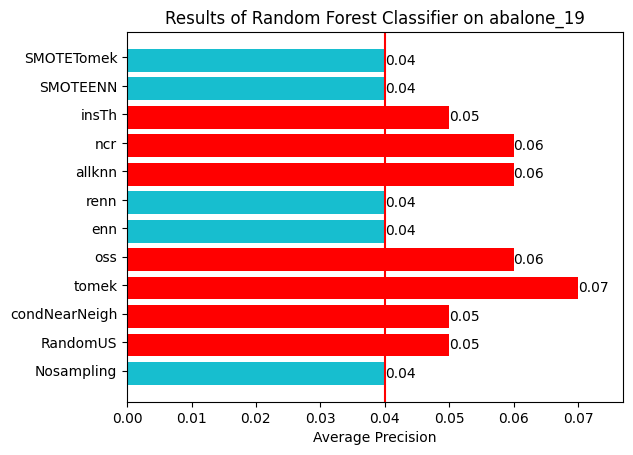

In [38]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": Random Forest average preicision scores  on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_rf = pd.Series(pr_mean_dict_rf[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_rf], index=["rf"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": Random Forest average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_rf = pd.Series(pr_mean_dict_rf[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_rf], index=["rf"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 12):
        if df["rf"][j] > df["rf"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(12)  # plotting for 12 different undersampling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df["rf"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["rf"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(12)],
        [
            "Nosampling",
            "RandomUS",
            "condNearNeigh",
            "tomek",
            "oss",
            "enn",
            "renn",
            "allknn",
            "ncr",
            "insTh",
            "SMOTEENN",
            "SMOTETomek",
        ],
    )
    maximum = df["rf"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title("Results of Random Forest Classifier on %s" % (all_datasets[i]["DESCR"]))
    ax.bar_label(ax.containers[0])
    plt.show()

----------------------------------------------------------------

Table 1: XGBoost average preicision scores on synthetic data, sep: 0.5
----------------------------------------------------------------

                     xgb
Nosampling          0.27
RandomUnderSampler  0.25
condNearNeigh       0.23
tomek               0.29
oss                 0.29
enn                 0.31
renn                0.29
allknn              0.30
ncr                 0.31
insTh               0.27
SMOTEENN            0.29
SMOTETomek          0.27
----------------------------------------------------------------

Table 2: XGBoost average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------

                     xgb
Nosampling          0.60
RandomUnderSampler  0.54
condNearNeigh       0.53
tomek               0.61
oss                 0.60
enn                 0.61
renn                0.55
allknn              0.61
ncr                 0.59
insTh              

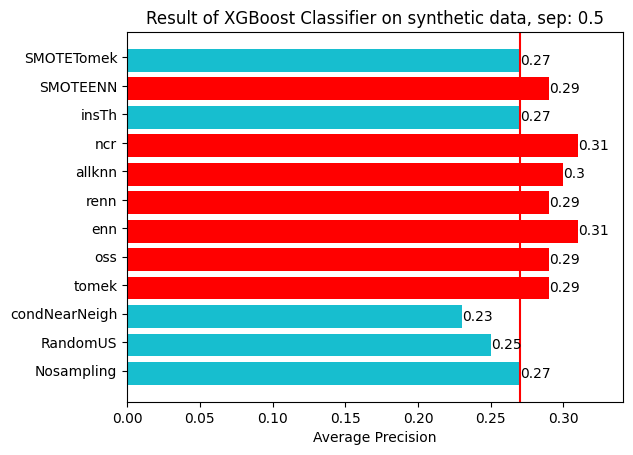

----------------------------------------------------------------

Figure 2: XGBoost average preicision scores on synthetic data, sep: 0.9
----------------------------------------------------------------



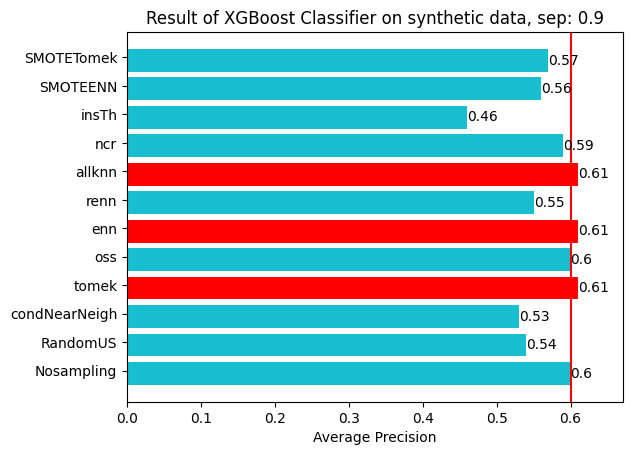

----------------------------------------------------------------

Figure 3: XGBoost average preicision scores on thyroid_sick
----------------------------------------------------------------



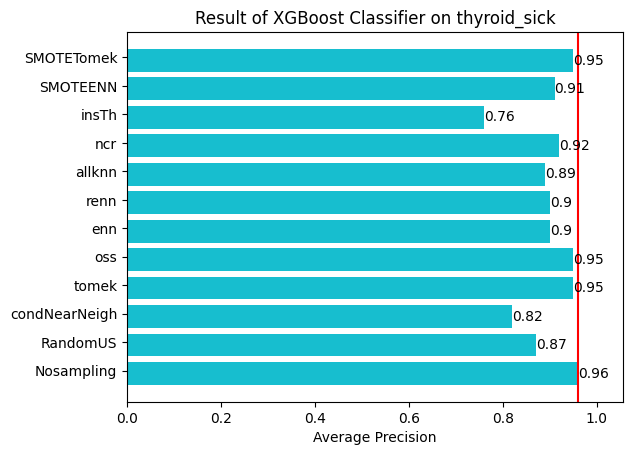

----------------------------------------------------------------

Figure 4: XGBoost average preicision scores on abalone_19
----------------------------------------------------------------



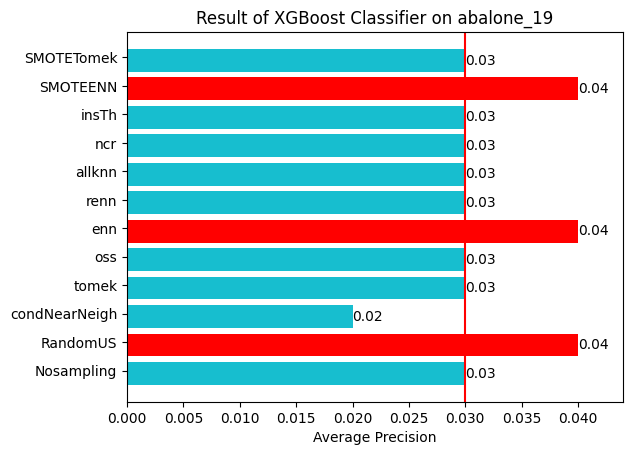

In [39]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": XGBoost average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_xgb], index=["xgb"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": XGBoost average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_xgb], index=["xgb"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 12):
        if df["xgb"][j] > df["xgb"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(12)  # plotting for 12 different undersampling techniques
    fig, ax = plt.subplots()
    bars = ax.barh(r, df["xgb"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["xgb"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(12)],
        [
            "Nosampling",
            "RandomUS",
            "condNearNeigh",
            "tomek",
            "oss",
            "enn",
            "renn",
            "allknn",
            "ncr",
            "insTh",
            "SMOTEENN",
            "SMOTETomek",
        ],
    )
    maximum = df["xgb"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    ax.bar_label(ax.containers[0])
    plt.title("Result of XGBoost Classifier on %s" % (all_datasets[i]["DESCR"]))
    plt.show()